# Peak detection using a neural network

In my PhD research, our group has been developing a new technique to study nanoparticles using mass spectrometry. Our technique allows us to continuously measure the mass of a single nanoparticle by measuring its frequency of motion in an electric field, and we are working on automating our measurements. If you are interested in the physics behind, check out https://en.wikipedia.org/wiki/Quadrupole_ion_trap

In order to measure the frequency, we do something called frequency sweeping and it can be shown below.

Let's import the necessary libraries and plot an example data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
%matplotlib inline

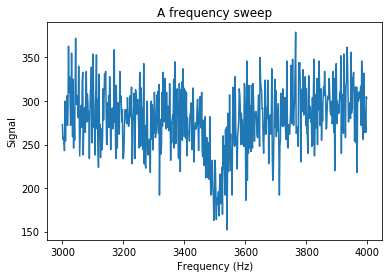

In [2]:
#reading a raw file of a frequency sweep
data = pd.read_csv("Scan 85.csv")
header = data.iloc[1] #specifying the header
data = data.iloc[2:,:] #specifying the data
data.columns=header #setting the header
#putting the data into x and y arrays. Also convert the data to float
cols = data.columns
data_x = data[cols[0]].astype(float)
data_y = data[cols[1]].astype(float)
#plot the data
plt.plot(data_x,data_y)
plt.title("A frequency sweep")
plt.ylabel("Signal")
plt.xlabel("Frequency (Hz)")
plt.show()

The figure above is showing a sweep where a "peak" (a dip in the signal) is present. We care about this because the peak indicates the particle's frequency. You can think of it as the particle responding to our measurement and giving us a peak in the signal. As the peak is not always in the frequency sweep range, it is important for us to reliably identify if the peak is present or not. 

It is not necessarily a straight forward precess to automate because of the varying background noise, peak width, peak depth, and background level affecting the performance of a simple detection algorithm. 

Enough of the details. Lets get into a machine learning approach for peak detection.

We lack labeled data and the inbalance of positive versus negative data. It may be possible that I use an anomaly detection approach, but it gets a bit tricky to train. 

To bypass these problems, I realized that it is actually easier to simulate the training data:

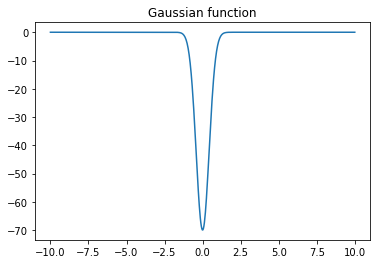

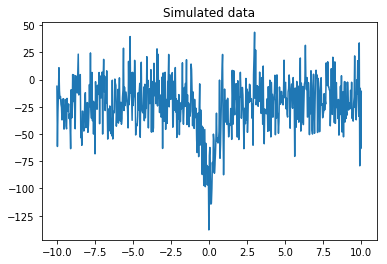

In [3]:
#simulate a gaussian peak
x = np.linspace(-10,10,600) #create an x array with 600 data points
def gaussian(x,mean,sigma,amplitude): #construct a gaussian function as a peak
    return amplitude*np.exp(-((x-mean)/sigma)**2)
y = gaussian(x,0,0.6,-70) 
plt.plot(x,y)
plt.title("Gaussian function")
plt.show()
#simulate background noise
noise = np.random.normal(-20,20,len(y)) #adding gaussian noise into the data
y_noisy = y+noise
plt.plot(x,y_noisy)
plt.title("Simulated data")
plt.show()

The simulated data looks quite similar to the real data. Now, lets generate a background without a peak present.

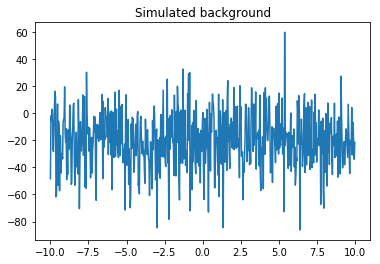

In [4]:
#simulate a baseline with noise
y_baseline = x*0
noise = np.random.normal(-20,20,len(y_baseline))
y_baseline += noise
plt.plot(x,y_baseline)
plt.title("Simulated background")
plt.show()

Then, I can build a function that randomly generate a sweep with or without a peak, with variable position, width,  amplitude, and noise.

In [5]:
def generate_scan(x):
    #generate random gaussian curve
    mean = np.linspace(min(x),max(x),100)[random.randrange(0,99)]
    sigma = np.linspace(0.5,2,100)[random.randrange(0,99)]
    amplitude = -np.linspace(10,100,100)[random.randrange(0,99)]
    rand = random.randint(0,1)
    if  rand == 0: #generate a peak
        y = gaussian(x,mean,sigma,amplitude)
        peak_present = 1
    elif rand == 1: #generate only a background
        y = x*0
        peak_present = 0
    #generate noise
    noise_level = np.linspace(10,30,100)[random.randrange(0,99)]
    noise = np.random.normal(-noise_level,noise_level,len(y))
    y_noisy = y+noise
    return y_noisy,peak_present

Adding a function that can generate a testing set with each sweep being the data and peak present or absent being the label.

In [6]:
#return data and label lists
def gen_dataset(x,N):
    #N is the number of data points
    data = []
    label = []
    #generate N number of sweeps
    for n in range(N):
        y, peak_present = generate_scan(x)
        data.append(y)
        label.append(peak_present)
    return np.array(data), np.array(label)
#let's generate 10,000 data points for the training set and 1,000 data points for the testing set.
x = np.linspace(-10,10,600)
X_train, y_train = gen_dataset(x,10000)
X_test, y_test = gen_dataset(x,1000)

The rest is quite simple. Just train a scikit-learn MLPClassifier to classify peaks and non-peaks.

In [9]:
from sklearn.neural_network import MLPClassifier
#lbfgs is an algorithm for minimizing the errors between the model and the data.
#alpha specifies the amount of regularization (to prevent any one of the weights dominating the outcome)
#The input layer of 600, then a hidden layer of 100, a hidden layer of 50, and finially the output layer of 2
#My idea is to slowly decreasing the number of neurons to the output layer of 2
clf = MLPClassifier(solver = "lbfgs", alpha = 1E-5, #construct a class
                   hidden_layer_sizes=(100,50))
clf.fit(X_train,y_train) #call the class function to train

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

Let's test out the performance of our model on the test set generated previously

In [10]:
from sklearn.metrics import classification_report
print(classification_report(y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.91      0.97      0.94       504
          1       0.97      0.90      0.94       496

avg / total       0.94      0.94      0.94      1000



This is quite good, with all the statistics higher than 90%. Although, it seems like the precision of class 0 and the recall of class 1 are both lower. That means that out of all the background, only 9/10 are predicted correctly. On the other hand, out of all the peaks predicted, only 9/10 are actual peaks. This means our model is predicting too many backgrounds as peaks.

One can generate a random scan and predict if a peak is present.

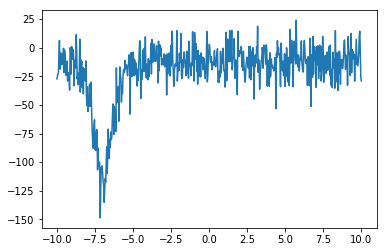

Prediction:  [1]
Actual:  1


In [11]:
y,peak = generate_scan(x)
plt.plot(x,y)
plt.show()
print("Prediction: ", clf.predict(np.array([y])))
print("Actual: ", peak)

Let's make it harder for the neural network. Now I am going to add a changing baseline (various slope and signal level) and different classes of peaks. Note that real data signal can have variations over several orders of magnitude and can have drifts during a sweep.

In [13]:
def generate_scan(x):
    #generate gaussian curve
    mean = np.linspace(min(x),max(x),100)[random.randrange(0,99)]
    rand = random.randint(0,1)
    # randomly choosing different peak types
    if  rand == 0:
        peak_types = random.randint(0,2)
        if peak_types == 0: #wide frequency scan (narrow and strong peaks)
            sigma_max, sigma_min = 0.1,0.3
            amplitude_max, amplitude_min = 200,250
        elif peak_types == 1: #mid frequency scan
            sigma_max, sigma_min = 0.5,0.7
            amplitude_max, amplitude_min = 100,200
        elif peak_types == 2: #narrow frequency scan (wide and maybe weak peaks)
            sigma_max, sigma_min = 1,2
            amplitude_max, amplitude_min = 80,150
        sigma = np.linspace(sigma_max,sigma_min,100)[random.randrange(0,99)]
        amplitude = -np.linspace(amplitude_max,amplitude_min,100)[random.randrange(0,99)]
        y = gaussian(x,mean,sigma,amplitude)
        peak_present = 1
    elif rand == 1: #baseline
        y = x*0
        peak_present = 0
    #making a random baseline
    b = np.linspace(1000,10000,100)[random.randrange(0,99)] #randomly changing the signal level
    m = np.linspace(-5,5,100)[random.randrange(0,99)] #randomly changing the slope
    y = y+(x*m+b)
    #generate noise
    noise_level = np.linspace(20,60,100)[random.randrange(0,99)]
    noise = np.random.normal(-noise_level,noise_level,len(y))
    y_noisy = y+noise
    return y_noisy,peak_present

Because there are variations over orders of magnitudes, we need to standardize the data.

In [14]:
import statistics
def preprocess(y):
    mean = statistics.mean(y)
    std = statistics.stdev(y)
    y = (y - mean)/std
    return y

Redefine the dataset generation function so that it preprocesses the data.

In [17]:
#return data and label lists
def gen_dataset(x,N):
    #N is the number of data points
    data = []
    label = []
    for n in range(N):
        y, peak_present = generate_scan(x)
        data.append(preprocess(y)) #preprocessing
        label.append(peak_present)
    return np.array(data), np.array(label)

Now, retrain the neural network. This time we are increasing the size of the training set to allow our model to learn the increased complexity.

In [19]:
x = np.linspace(-10,10,600)
X_train, y_train = gen_dataset(x,20000)
X_test, y_test = gen_dataset(x,1000)
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver = "lbfgs", alpha = 1E-5,
                   hidden_layer_sizes=(100,50,10))
clf.fit(X_train,y_train)
from sklearn.metrics import classification_report
print(classification_report(y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.95      0.95      0.95       514
          1       0.95      0.94      0.95       486

avg / total       0.95      0.95      0.95      1000



The results are quite good. One caveat of using simulated data to train a model is that we run the risk of overfitting the simulated dataset. Thus, we have to simulate the data as close to the real data as possible.